In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

In [2]:
plt.rcParams['font.family'] = 'Microsoft YaHei' 

## 数据概览

### 数据读取

In [3]:
data = pd.read_csv("D:\BaiduSyncdisk\机器学习\shangji\data\Credit_card.csv")  # 读取特征数据

In [4]:
data_label = pd.read_csv("D:\BaiduSyncdisk\机器学习\shangji\data\Credit_card_label.csv")  # 读取类别数据

In [5]:
data.shape

(1548, 18)

In [6]:
data_label.shape

(1548, 2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548 entries, 0 to 1547
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ind_ID           1548 non-null   int64  
 1   GENDER           1541 non-null   object 
 2   Car_Owner        1548 non-null   object 
 3   Propert_Owner    1548 non-null   object 
 4   CHILDREN         1548 non-null   int64  
 5   Annual_income    1525 non-null   float64
 6   Type_Income      1548 non-null   object 
 7   EDUCATION        1548 non-null   object 
 8   Marital_status   1548 non-null   object 
 9   Housing_type     1548 non-null   object 
 10  Birthday_count   1526 non-null   float64
 11  Employed_days    1548 non-null   int64  
 12  Mobile_phone     1548 non-null   int64  
 13  Work_Phone       1548 non-null   int64  
 14  Phone            1548 non-null   int64  
 15  EMAIL_ID         1548 non-null   int64  
 16  Type_Occupation  1060 non-null   object 
 17  Family_Members

可以看到GENDER，Annual_income，Birthday_count，Type_Occupation列存在缺失值

各字段意义如下：

| 字段| 说明|
|:-----|:-----:|
| Ind_ID|客户ID|
|Gender	|性别信息|
|Car_owner|	是否有车|
|Propert_owner|	是否有房产|
|Children|	子女数量|
|Annual_income|	年收入|
|Type_Income|	收入类型|
|Education|	教育程度|
|Marital_status	|婚姻状况|
|Housing_type|	居住方式|
|Birthday_count	|以当前日期为0，往前倒数天数|
|Employed_days	|就业开始日期。当前日期为0，往前倒数天数（正值则意味着个人目前未就业）|
|Mobile_phone	|手机号码|
|Work_phone	|工作电话|
|Phone	|电话号码|
|EMAIL_ID|	电子邮箱|
|Type_Occupation|	职业|
|Family_Members|	家庭人数|

In [8]:
data_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548 entries, 0 to 1547
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Ind_ID  1548 non-null   int64
 1   label   1548 non-null   int64
dtypes: int64(2)
memory usage: 24.3 KB


In [9]:
data = pd.merge(data, data_label, on="Ind_ID")  # 将特征和类别按照对应的ID进行拼接
data.shape

(1548, 19)

In [10]:
data.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1


### 绘制箱线图

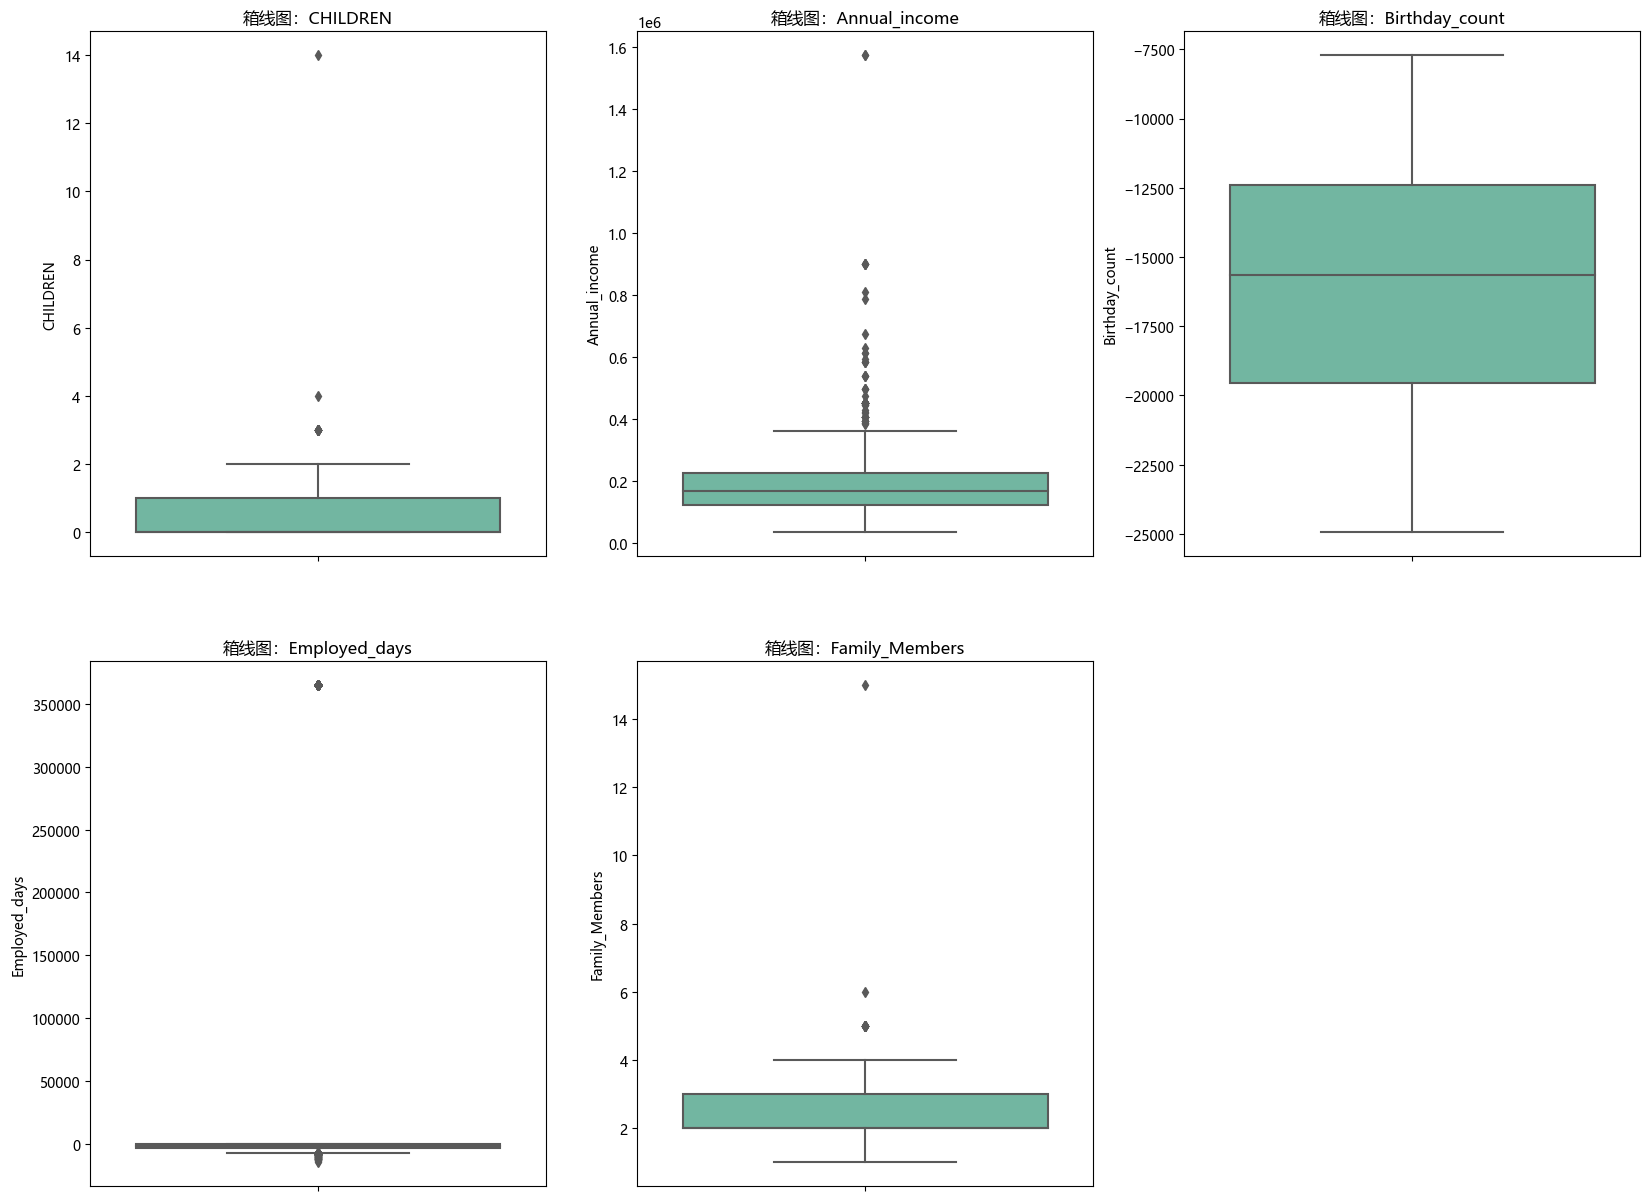

In [11]:
columns = ['CHILDREN', 'Annual_income', 'Birthday_count', 'Employed_days', 'Family_Members']  # 对数值型数据绘制箱线图
plt.figure(figsize=(20,15))
for i,col in enumerate(columns,1):
    plt.subplot(2,3,i)
    sns.boxplot(y=data[col],palette="Set2")
    plt.title(f'箱线图：{col}')

可以看到：
* CHILDREN列有个值为14，可能是异常值
* Employed_days列有个很大的正值，换算成年将近1000年，可能为异常值
* Family_Members列有个极大值为15，可能是异常值

### 数据处理

#### 1.数据类型转换

In [12]:
data['Ind_ID'] = data['Ind_ID'].astype(str) #将Ind_ID转化为object格式

#### 2.缺失值处理

In [13]:
gender_mode = data['GENDER'].mode()[0]
data['GENDER'].fillna(gender_mode,inplace=True)  # 对‘GENDER'的缺失值采用众数填充

data['Type_Occupation'].fillna('unknown',inplace=True)  # 对‘Type_Occupation'的缺失值填充“unknown”

annual_income_median = data['Annual_income'].median()
data['Annual_income'].fillna(annual_income_median,inplace=True)  # 对‘Annual_income’的缺失值采用中位数填充

birthday_count_median = data['Birthday_count'].median()
data['Birthday_count'].fillna(birthday_count_median,inplace=True)  # 对‘Birthday_count’的缺失值采用中位数填充

In [14]:
data.isna().sum()

Ind_ID             0
GENDER             0
Car_Owner          0
Propert_Owner      0
CHILDREN           0
Annual_income      0
Type_Income        0
EDUCATION          0
Marital_status     0
Housing_type       0
Birthday_count     0
Employed_days      0
Mobile_phone       0
Work_Phone         0
Phone              0
EMAIL_ID           0
Type_Occupation    0
Family_Members     0
label              0
dtype: int64

#### 3.数据转换

In [15]:
data['Age'] = (-data['Birthday_count'] / 365).astype(int)  # 将‘Birthday_count’列转化为‘Age’列
data.drop('Birthday_count',axis=1, inplace=True)

In [16]:
data.isna().sum()

Ind_ID             0
GENDER             0
Car_Owner          0
Propert_Owner      0
CHILDREN           0
Annual_income      0
Type_Income        0
EDUCATION          0
Marital_status     0
Housing_type       0
Employed_days      0
Mobile_phone       0
Work_Phone         0
Phone              0
EMAIL_ID           0
Type_Occupation    0
Family_Members     0
label              0
Age                0
dtype: int64

#### 4.异常数据处理

In [17]:
data.loc[data['CHILDREN'] == 14, 'CHILDREN'] = data['CHILDREN'].median()  # 使用中位数替换异常值

data.loc[data['Family_Members'] == 15, 'Family_Members'] = data['Family_Members'].median() # 使用中位数替换异常值

In [18]:
#查看'Employed_days'正值的情况
positive_employed_days = data[data['Employed_days'] > 0]['Employed_days']
positive_employed_days.describe()

count       261.0
mean     365243.0
std           0.0
min      365243.0
25%      365243.0
50%      365243.0
75%      365243.0
max      365243.0
Name: Employed_days, dtype: float64

可以看出，共有261行数据的“Employed_days”为正值，且值都相同，均为365243。故365243可能代表特殊含义

In [19]:
positive_employed_data = data[data['Employed_days'] == 365243]
positive_employed_data.describe()  # “Employed_days”为正值的数值型特征概览

,CHILDREN,Annual_income,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,label,Age
count,261.000000,261.000000,261.0,261.0,261.0,261.000000,261.000000,261.000000,261.000000,261.000000
mean,0.034483,151277.396552,365243.0,1.0,0.0,0.306513,0.015326,1.659004,0.134100,59.199234
std,0.237694,81253.131354,0.0,0.0,0.0,0.461931,0.123081,0.563817,0.341414,5.457401
min,0.000000,33750.000000,365243.0,1.0,0.0,0.000000,0.000000,1.000000,0.000000,35.000000
25%,0.000000,99000.000000,365243.0,1.0,0.0,0.000000,0.000000,1.000000,0.000000,57.000000
50%,0.000000,135000.000000,365243.0,1.0,0.0,0.000000,0.000000,2.000000,0.000000,60.000000
75%,0.000000,180000.000000,365243.0,1.0,0.0,1.000000,0.000000,2.000000,0.000000,63.000000
max,3.000000,630000.000000,365243.0,1.0,0.0,1.000000,1.000000,5.000000,1.000000,68.000000


In [20]:
explore_data = data[data['Employed_days'] == 365243][['Type_Income', 'Type_Occupation']]
type_income_counts = explore_data['Type_Income'].value_counts()
type_occupation_counts = explore_data['Type_Occupation'].value_counts()
print(type_income_counts) 
print("-----------------")
print(type_occupation_counts)

Type_Income
Pensioner    261
Name: count, dtype: int64
-----------------
Type_Occupation
unknown    261
Name: count, dtype: int64


发现，所有“Employed_days”为正值的行，其'Type_Income'和'Type_Occupation'均相同，分别为**Pensioner（退休人士）**和**unknown**

In [21]:
#将“Employed_days”为正值的行的'Type_Occupation'列设置成成'Pensioner'
data.loc[data['Employed_days'] == 365243, 'Type_Occupation'] = 'Pensioner'

In [22]:
data['Is_Retired'] = (data['Employed_days'] == 365243).astype(int)  # #创建一个新的二元特征 "Is_Retired"，为退休人员设置为1，其他人为0
data.loc[data['Employed_days'] == 365243, 'Employed_days'] = 0  # 将Employed_days列中的正值转换为0

In [23]:
#将Employed_days转化为Employed_years
data['Employed_years'] = (-data['Employed_days'] / 365).astype(int)
#删除'Employed_days'
data.drop('Employed_days',axis=1, inplace=True)

In [24]:
data.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label,Age,Is_Retired,Employed_years
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,1,0,0,0,Pensioner,2,1,51,1,0
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,1,1,1,0,unknown,2,1,37,0,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,1,1,1,0,unknown,2,1,42,0,1
3,5009749,F,Y,N,0,166500.0,Commercial associate,Higher education,Married,House / apartment,1,1,1,0,unknown,2,1,37,0,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,1,1,1,0,unknown,2,1,37,0,1


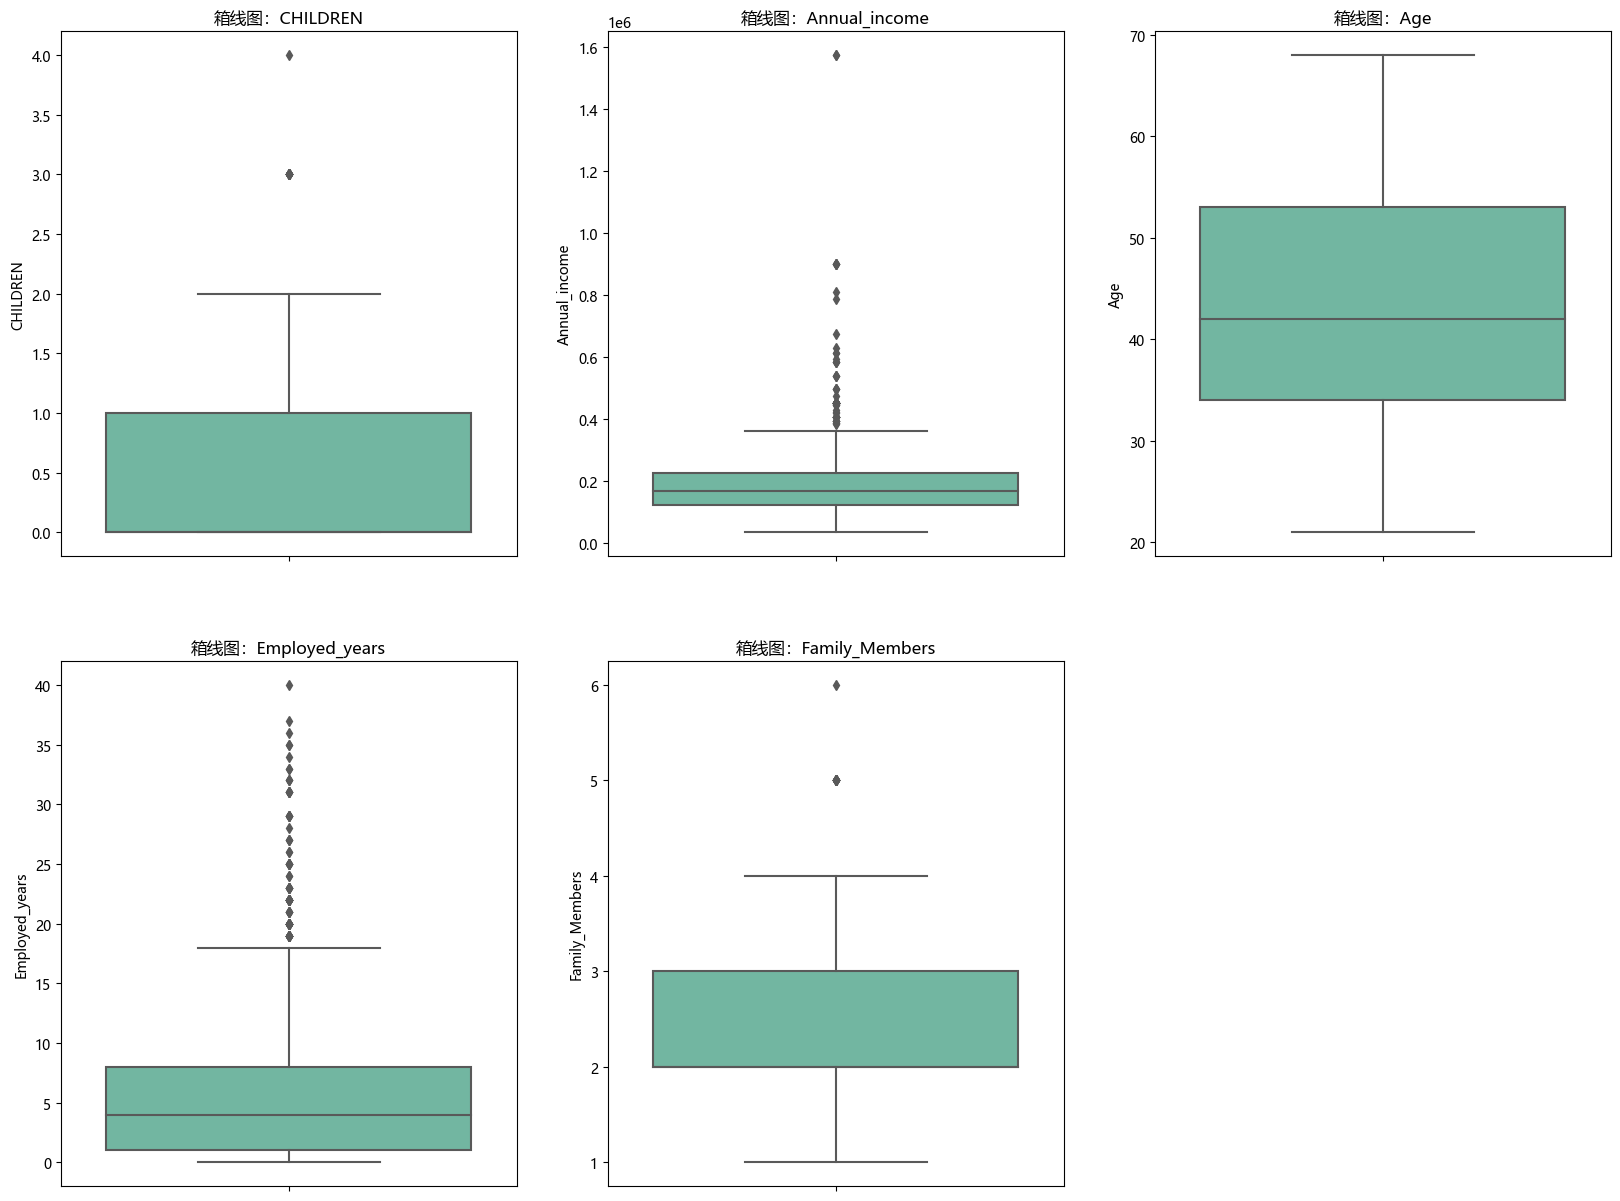

In [25]:
columns = ['CHILDREN', 'Annual_income', 'Age', 'Employed_years', 'Family_Members']  # 对数值型数据绘制箱线图
plt.figure(figsize=(20,15))
for i,col in enumerate(columns,1):
    plt.subplot(2,3,i)
    sns.boxplot(y=data[col],palette="Set2")
    plt.title(f'箱线图：{col}')

## 数据探索

### 1.数值型变量

<Figure size 2000x1500 with 0 Axes>

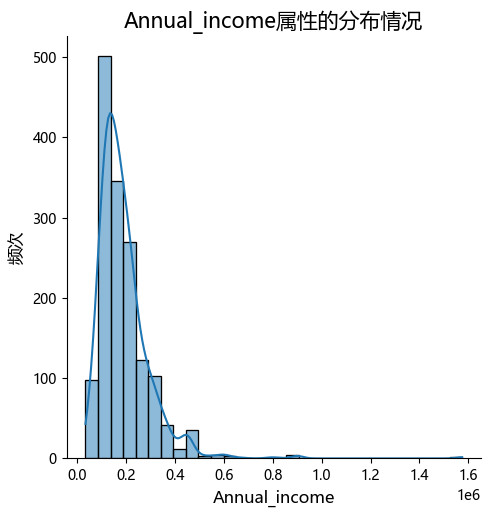

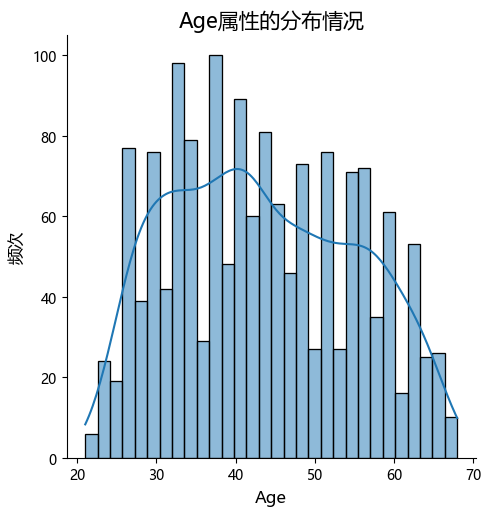

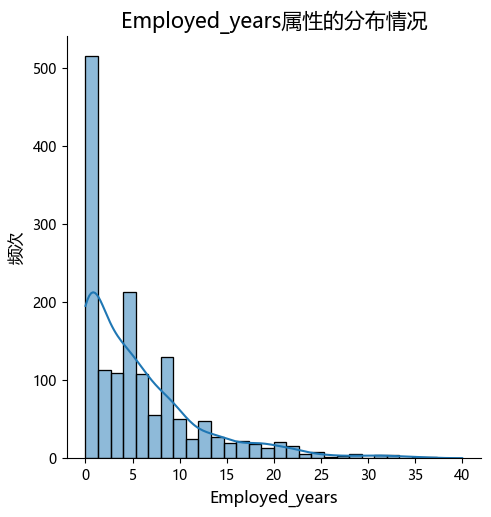

In [26]:
import warnings
warnings.filterwarnings("ignore")


numerical_columns = ['Annual_income', 'Age', 'Employed_years']
plt.figure(figsize=(20, 15))
for i, column in enumerate(numerical_columns, 1):
    sns.displot(data[column], kde=True, bins=30)
    plt.title(f'{column}属性的分布情况', fontsize=15)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('频次', fontsize=12)
    plt.show()

* 大多数人收入较低，极少数人收入较高
* 年龄分布在20岁—70岁间，分布较为均匀
* 大多数人工龄较低，其中为0的占多数，这部分可能是由于将退休人员的工龄也设置为0

### 2.分类变量

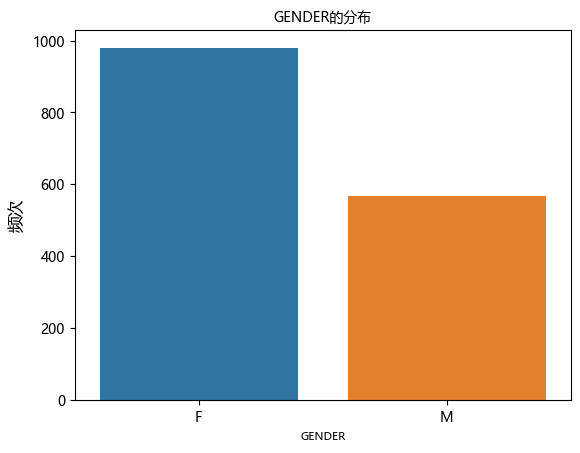

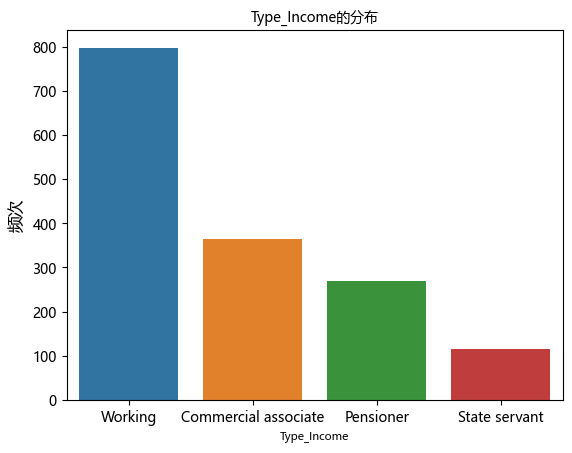

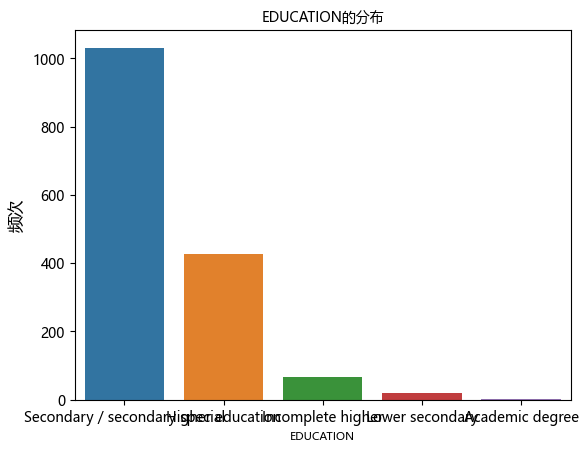

In [27]:
categorical_columns = ['GENDER', 'Type_Income', 'EDUCATION']

for i, column in enumerate(categorical_columns, 1):
    sns.countplot(data=data, x=column, order=data[column].value_counts().index)
    plt.title(f'{column}的分布', fontsize=10)
    plt.xlabel(column, fontsize=8)
    plt.ylabel('频次', fontsize=12)
    plt.xticks(rotation=0)
    plt.show()

可以发现：
* 数据集中女性数量多于男性
* 收入类型中，Working类型占大多数
* 学历背景中，大多数人属于中等教育，极少人拥有高学历或低学历

### 3.申请结果分布

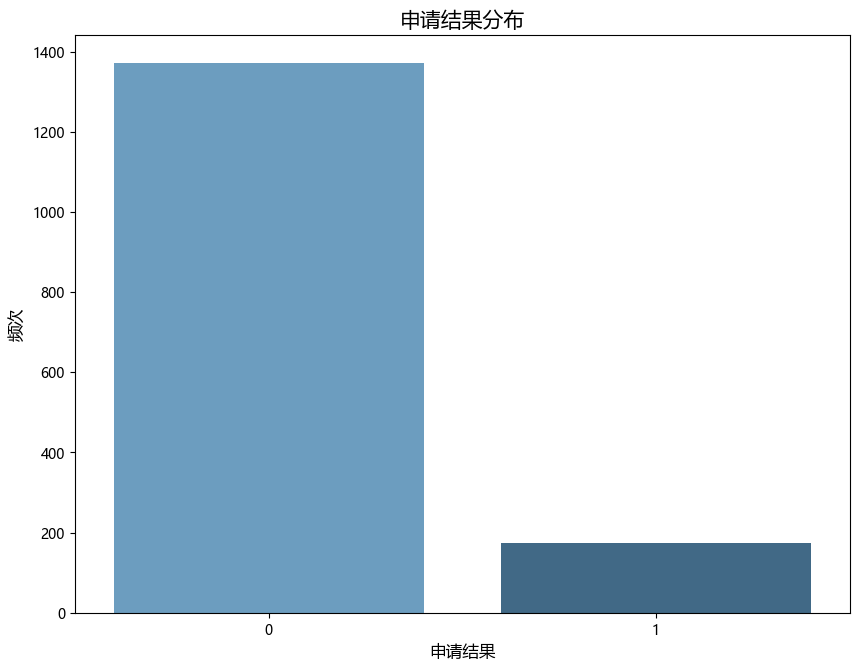

In [28]:
plt.figure(figsize=(10, 7.5))
ax = sns.countplot(data=data, x='label', palette="Blues_d")
plt.title('申请结果分布', fontsize=15)
plt.xlabel('申请结果', fontsize=12)
plt.ylabel('频次', fontsize=12)

plt.show()

可以明显看出数据集中通过的样本量明显多于不通过的样本量

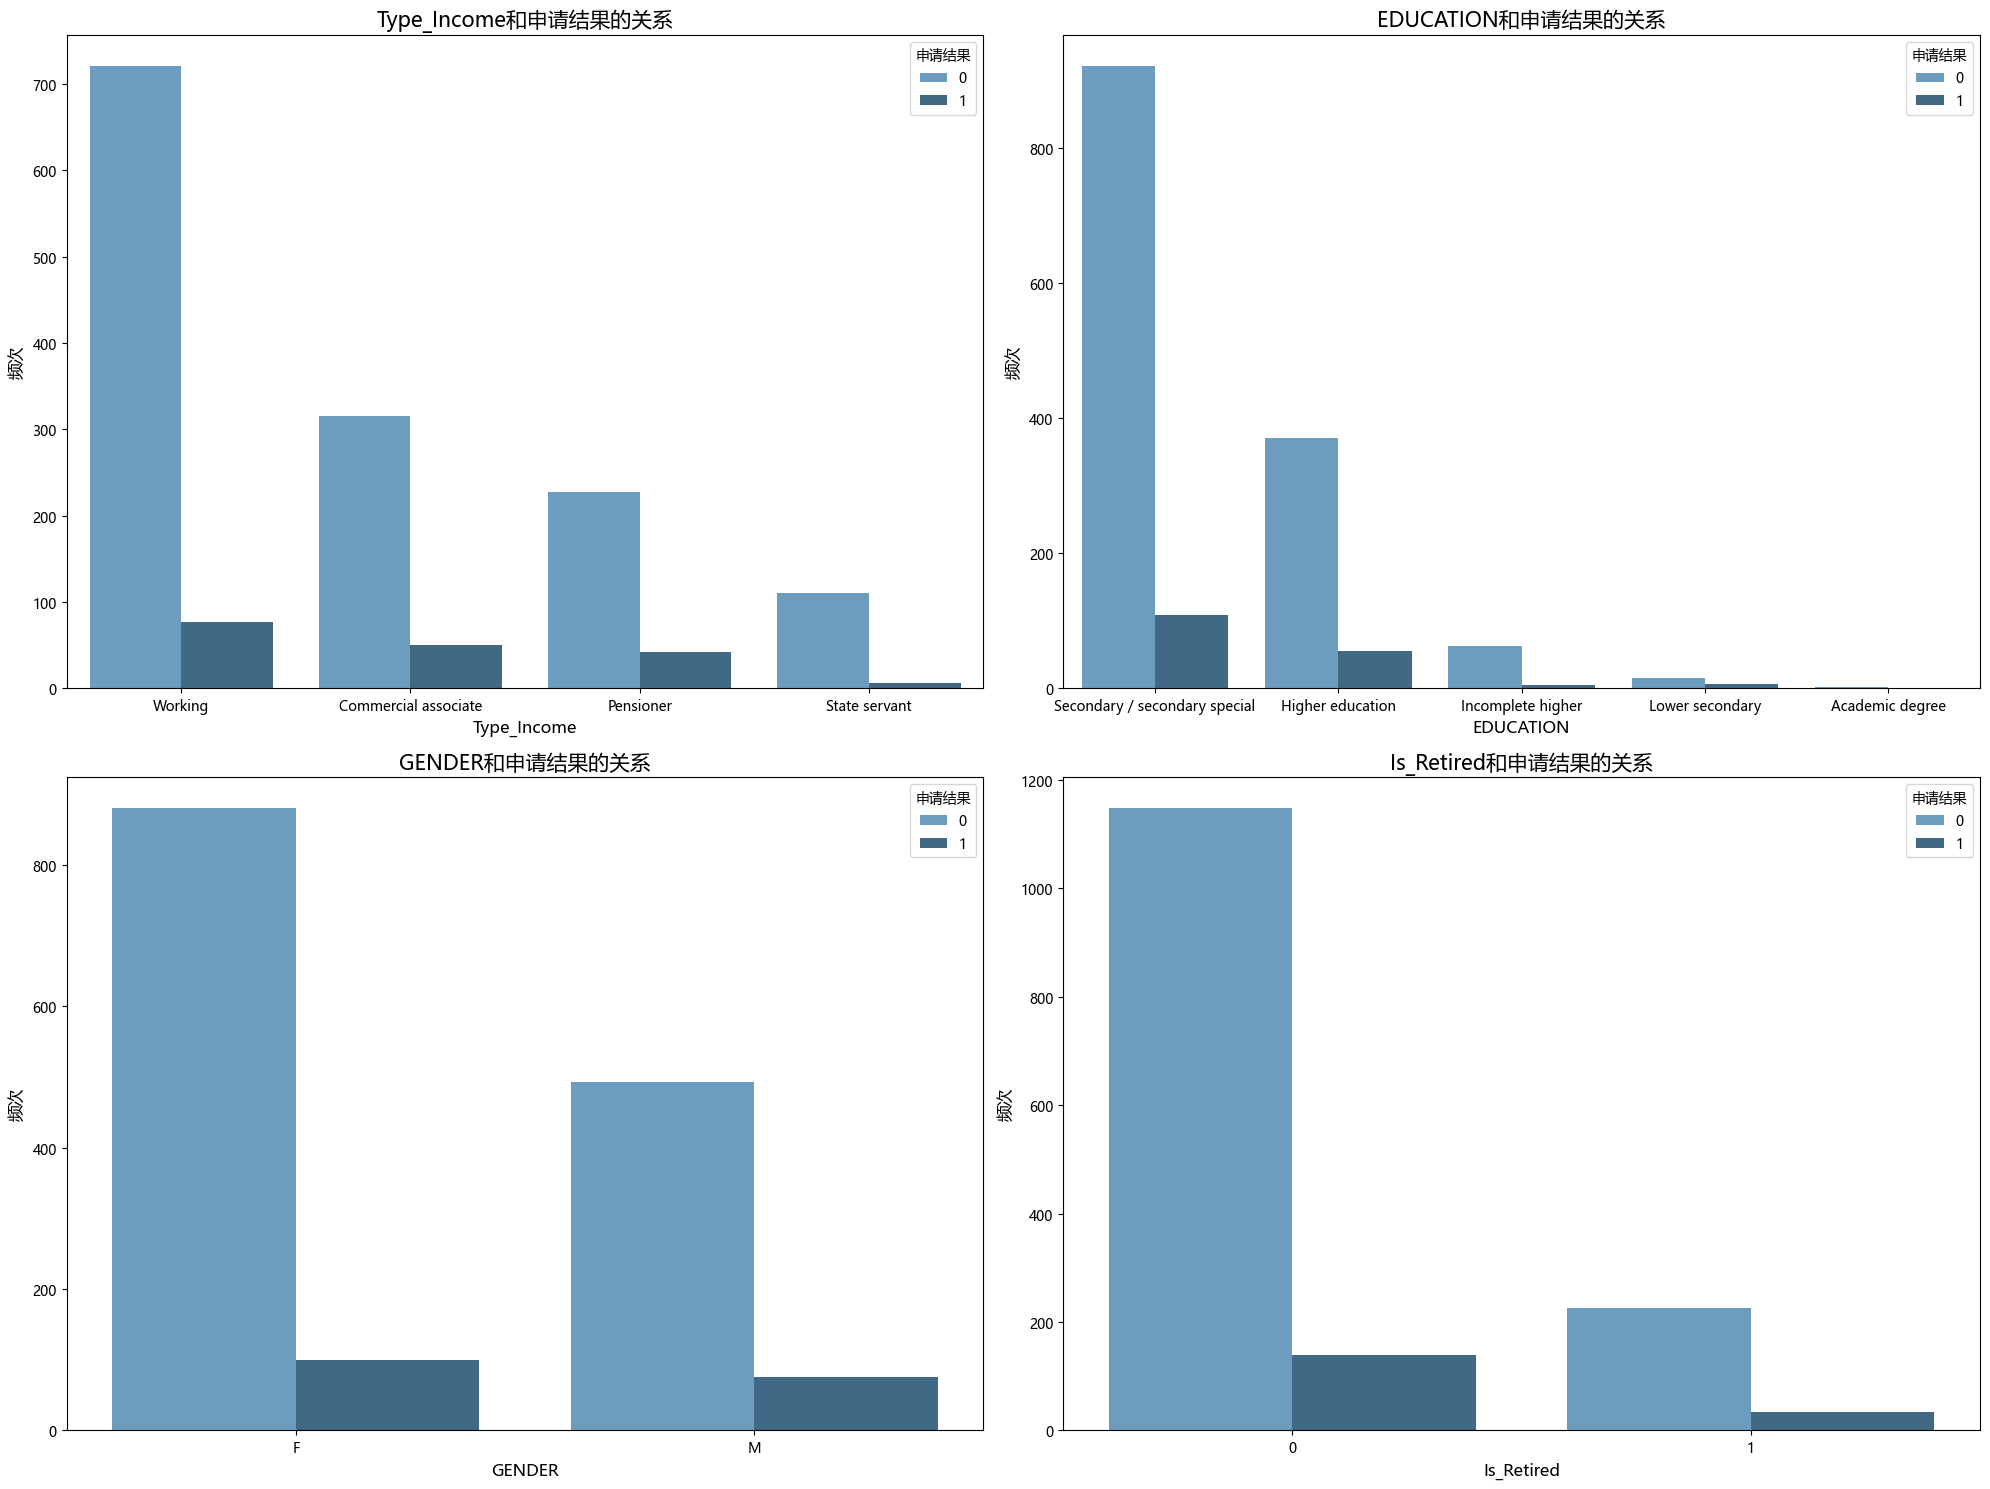

In [29]:
relationship_columns = ['Type_Income', 'EDUCATION', 'GENDER', 'Is_Retired']

plt.figure(figsize=(20, 15))

for i, column in enumerate(relationship_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=data, x=column, hue='label', palette="Blues_d", order=data[column].value_counts().index)
    plt.title(f'{column}和申请结果的关系', fontsize=15)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('频次', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='申请结果')

plt.tight_layout()
plt.show()

## 用户画像

### 1.通过申请的用户

In [30]:
approved_data = data[data['label'] == 0] #通过申请的用户数据

approved_profile = {
    'Gender Distribution': approved_data['GENDER'].value_counts(normalize=True),
    'Average Annual Income': approved_data['Annual_income'].mean(),
    'Education Distribution': approved_data['EDUCATION'].value_counts(normalize=True),
    'Car Ownership Distribution': approved_data['Car_Owner'].value_counts(normalize=True),
    'Property Ownership Distribution': approved_data['Propert_Owner'].value_counts(normalize=True),
    'Average Age': approved_data['Age'].mean(),
    'Occupation Distribution': approved_data['Type_Occupation'].value_counts(normalize=True),
    'Marital Status Distribution': approved_data['Marital_status'].value_counts(normalize=True)
}
print(approved_profile)

{'Gender Distribution': GENDER
F    0.640932
M    0.359068
Name: proportion, dtype: float64, 'Average Annual Income': 190049.14238892935, 'Education Distribution': EDUCATION
Secondary / secondary special    0.671522
Higher education                 0.270211
Incomplete higher                0.045885
Lower secondary                  0.010925
Academic degree                  0.001457
Name: proportion, dtype: float64, 'Car Ownership Distribution': Car_Owner
N    0.594319
Y    0.405681
Name: proportion, dtype: float64, 'Property Ownership Distribution': Propert_Owner
Y    0.655499
N    0.344501
Name: proportion, dtype: float64, 'Average Age': 43.2367079388201, 'Occupation Distribution': Type_Occupation
Laborers                 0.174800
Pensioner                0.164603
unknown                  0.149308
Core staff               0.109978
Managers                 0.088857
Sales staff              0.081573
Drivers                  0.056082
High skill tech staff    0.042243
Medicine staff       

### 2.未通过申请的用户

In [31]:
rejected_data = data[data['label'] == 1] # 申请未通过的用户数据

rejected_profile = {
    'Gender Distribution': rejected_data['GENDER'].value_counts(normalize=True),
    'Average Annual Income': rejected_data['Annual_income'].mean(),
    'Education Distribution': rejected_data['EDUCATION'].value_counts(normalize=True),
    'Car Ownership Distribution': rejected_data['Car_Owner'].value_counts(normalize=True),
    'Property Ownership Distribution': rejected_data['Propert_Owner'].value_counts(normalize=True),
    'Average Age': rejected_data['Age'].mean(),
    'Occupation Distribution': rejected_data['Type_Occupation'].value_counts(normalize=True),
    'Marital Status Distribution': rejected_data['Marital_status'].value_counts(normalize=True)
}
print(rejected_profile)

{'Gender Distribution': GENDER
F    0.571429
M    0.428571
Name: proportion, dtype: float64, 'Average Annual Income': 198720.0, 'Education Distribution': EDUCATION
Secondary / secondary special    0.622857
Higher education                 0.314286
Lower secondary                  0.034286
Incomplete higher                0.028571
Name: proportion, dtype: float64, 'Car Ownership Distribution': Car_Owner
N    0.617143
Y    0.382857
Name: proportion, dtype: float64, 'Property Ownership Distribution': Propert_Owner
Y    0.628571
N    0.371429
Name: proportion, dtype: float64, 'Average Age': 44.85142857142857, 'Occupation Distribution': Type_Occupation
Pensioner                0.200000
Laborers                 0.160000
Core staff               0.131429
unknown                  0.125714
Managers                 0.080000
Sales staff              0.057143
Drivers                  0.051429
Security staff           0.045714
High skill tech staff    0.040000
Accountants              0.028571
Cook

### 3.对比分析

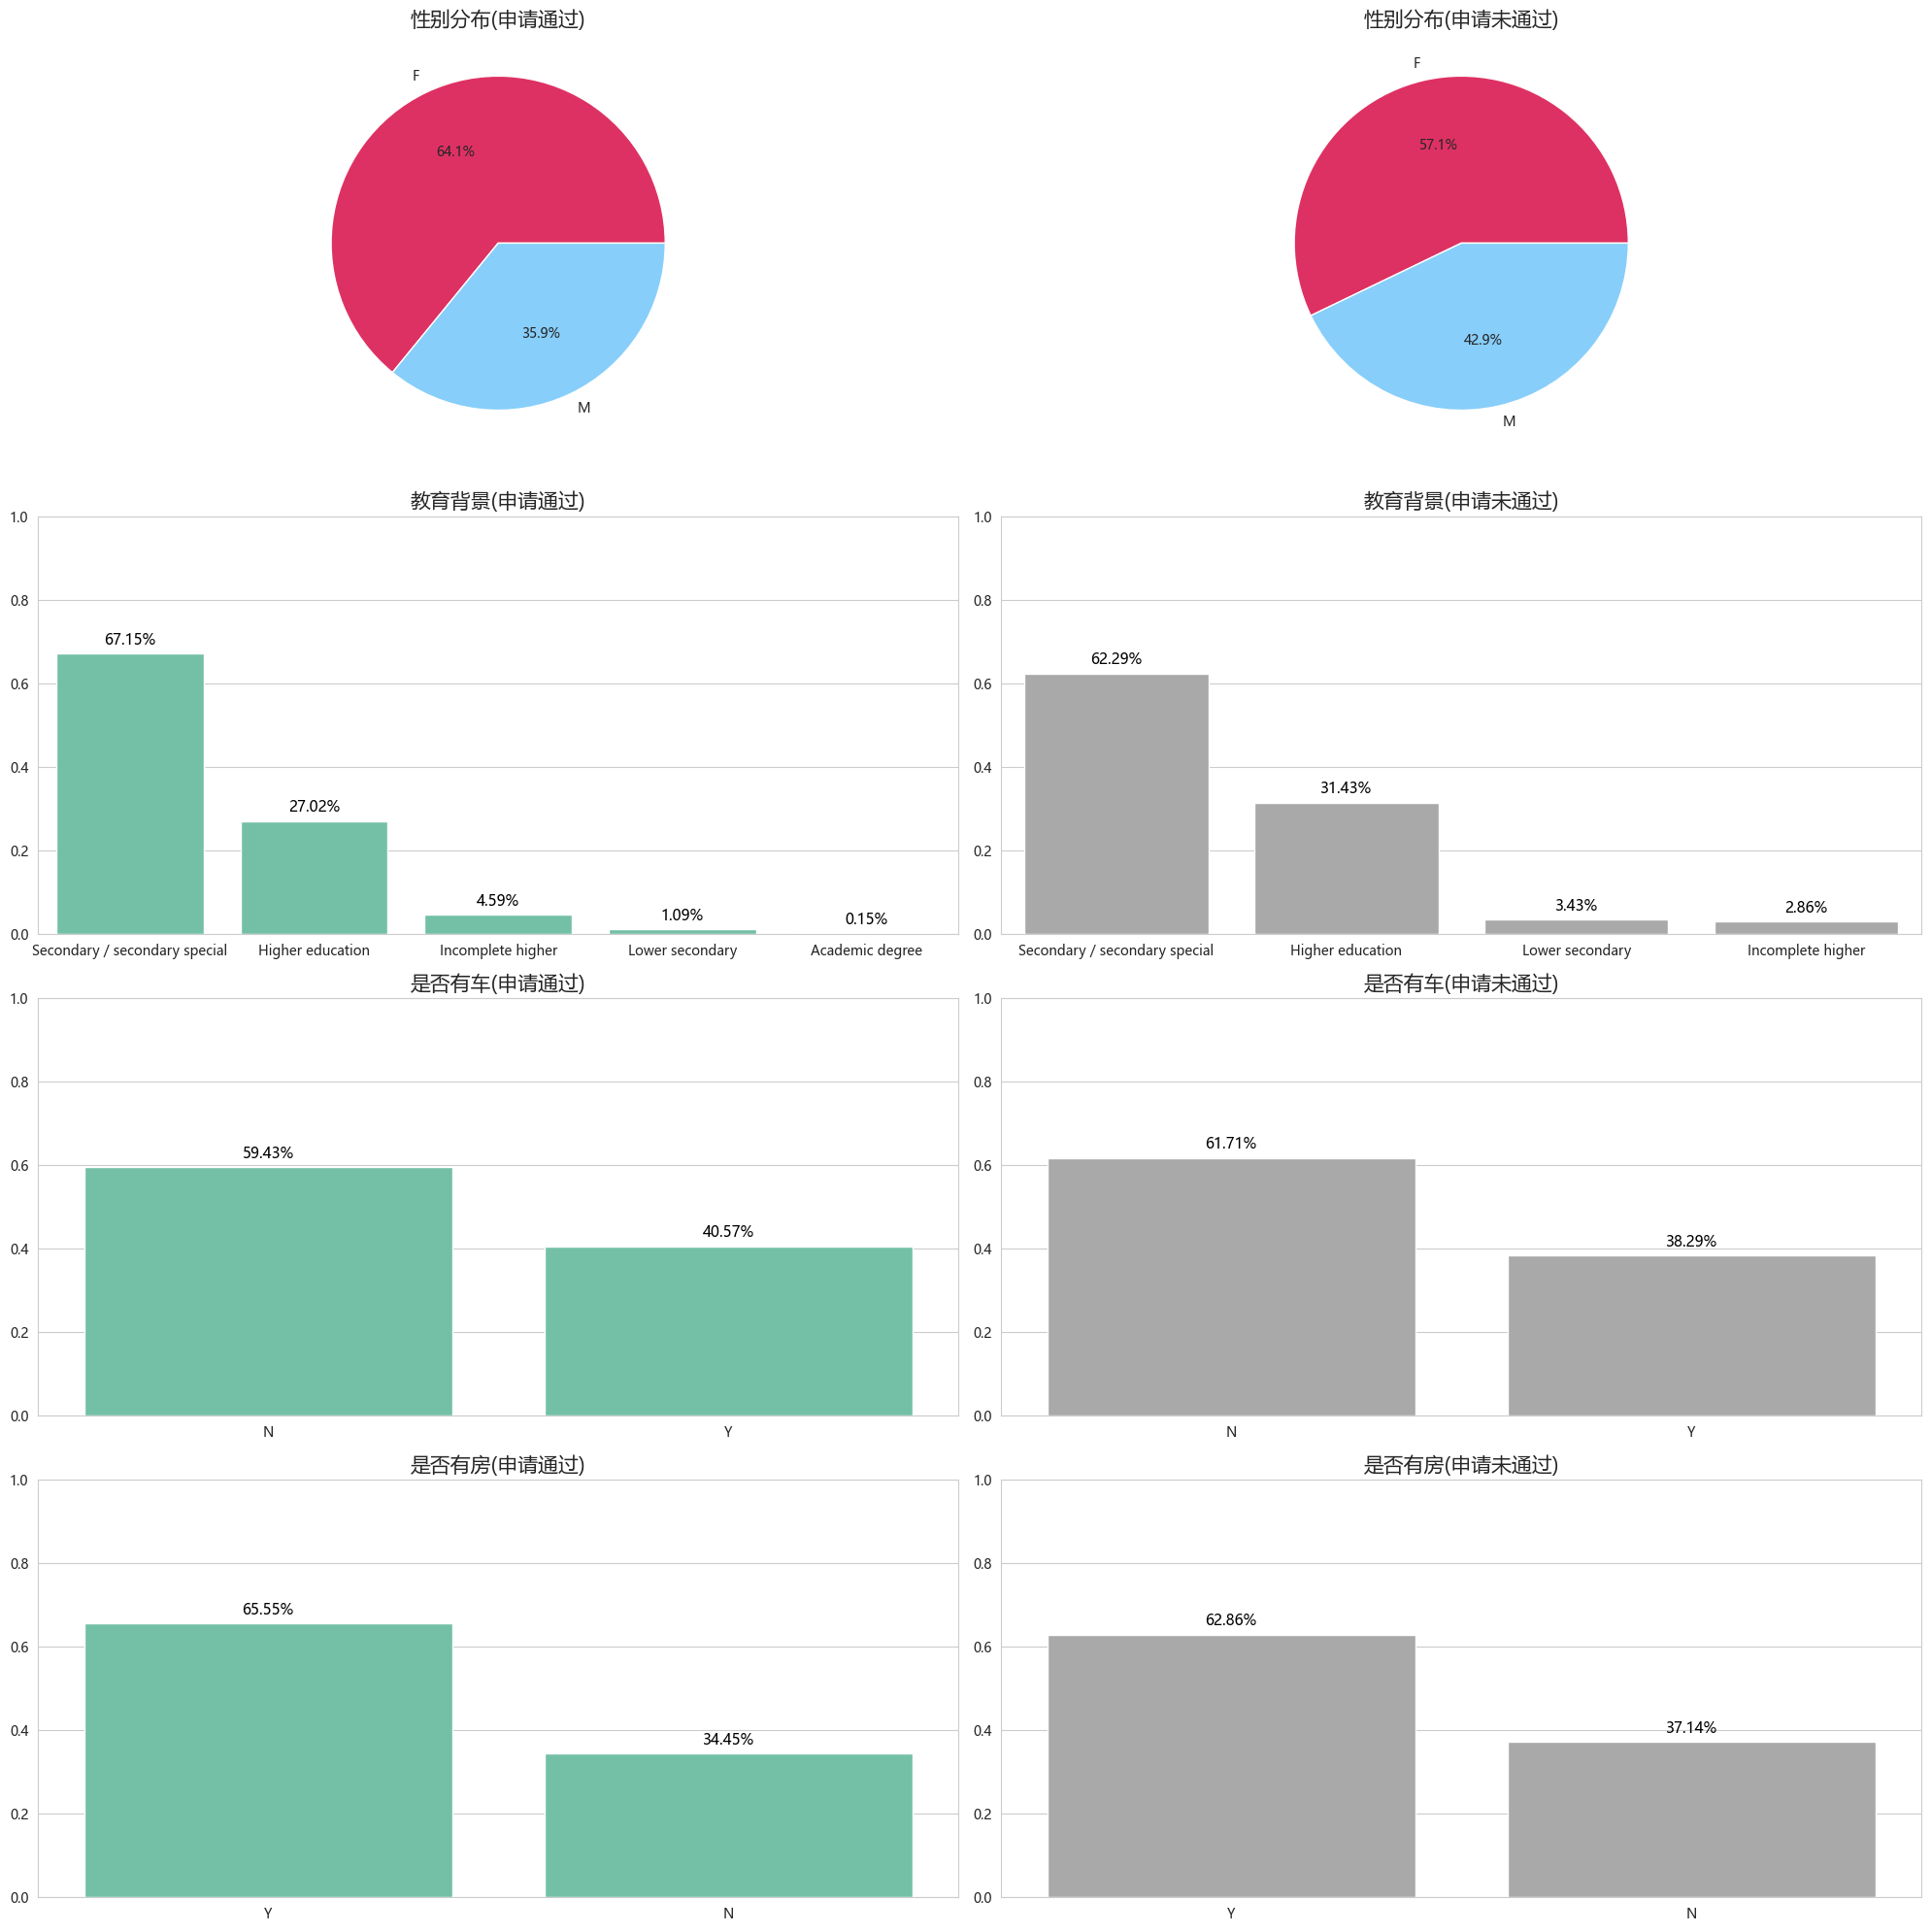

In [32]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 20))
plt.rcParams['font.family'] = 'Microsoft YaHei' 

#性别
ax1 = plt.subplot(4, 2, 1)
approved_profile['Gender Distribution'].plot(kind='pie', ax=ax1, autopct='%1.1f%%',colors=['#de3163', '#87cefa'])
ax1.set_title('性别分布(申请通过)', fontsize=15)
ax1.set_ylabel('')

ax2 = plt.subplot(4, 2, 2)
rejected_profile['Gender Distribution'].plot(kind='pie', ax=ax2, autopct='%1.1f%%',colors=['#de3163', '#87cefa'])
ax2.set_title('性别分布(申请未通过)', fontsize=15)
ax2.set_ylabel('')

# 绘制条形图
def bar_plot_with_annotation(ax, series, title, color):
    sns.barplot(x=series.index, y=series.values, ax=ax, color=color)
    ax.set_title(title, fontsize=15)
    ax.set_ylabel('')
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()*100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                    textcoords='offset points')
    ax.set_ylim(0, 1)
    
    
#教育背景
ax3 = plt.subplot(4, 2, 3)
bar_plot_with_annotation(ax3, approved_profile['Education Distribution'], '教育背景(申请通过)', '#66cdaa')

ax4 = plt.subplot(4, 2, 4)
bar_plot_with_annotation(ax4, rejected_profile['Education Distribution'], '教育背景(申请未通过)', '#a9a9a9')

#是否有车
ax5 = plt.subplot(4, 2, 5)
bar_plot_with_annotation(ax5, approved_profile['Car Ownership Distribution'], '是否有车(申请通过)', '#66cdaa')

ax6 = plt.subplot(4, 2, 6)
bar_plot_with_annotation(ax6, rejected_profile['Car Ownership Distribution'], '是否有车(申请未通过)', '#a9a9a9')

#是否有房
ax7 = plt.subplot(4, 2, 7)
bar_plot_with_annotation(ax7, approved_profile['Property Ownership Distribution'], '是否有房(申请通过)', '#66cdaa')

ax8 = plt.subplot(4, 2, 8)
bar_plot_with_annotation(ax8, rejected_profile['Property Ownership Distribution'], '是否有房(申请未通过)', '#a9a9a9')

plt.tight_layout()
plt.show()

从上图可以看出：
* 女性申请者相较于男性申请者更加容易通过
* 有房、有车的申请者相较于无房、无车的申请者更加容易通过
* 不过差距不大
* 另外一个有意思的点是，Academic degree教育背景的申请者全部通过，这可能与样本资料的限制有关

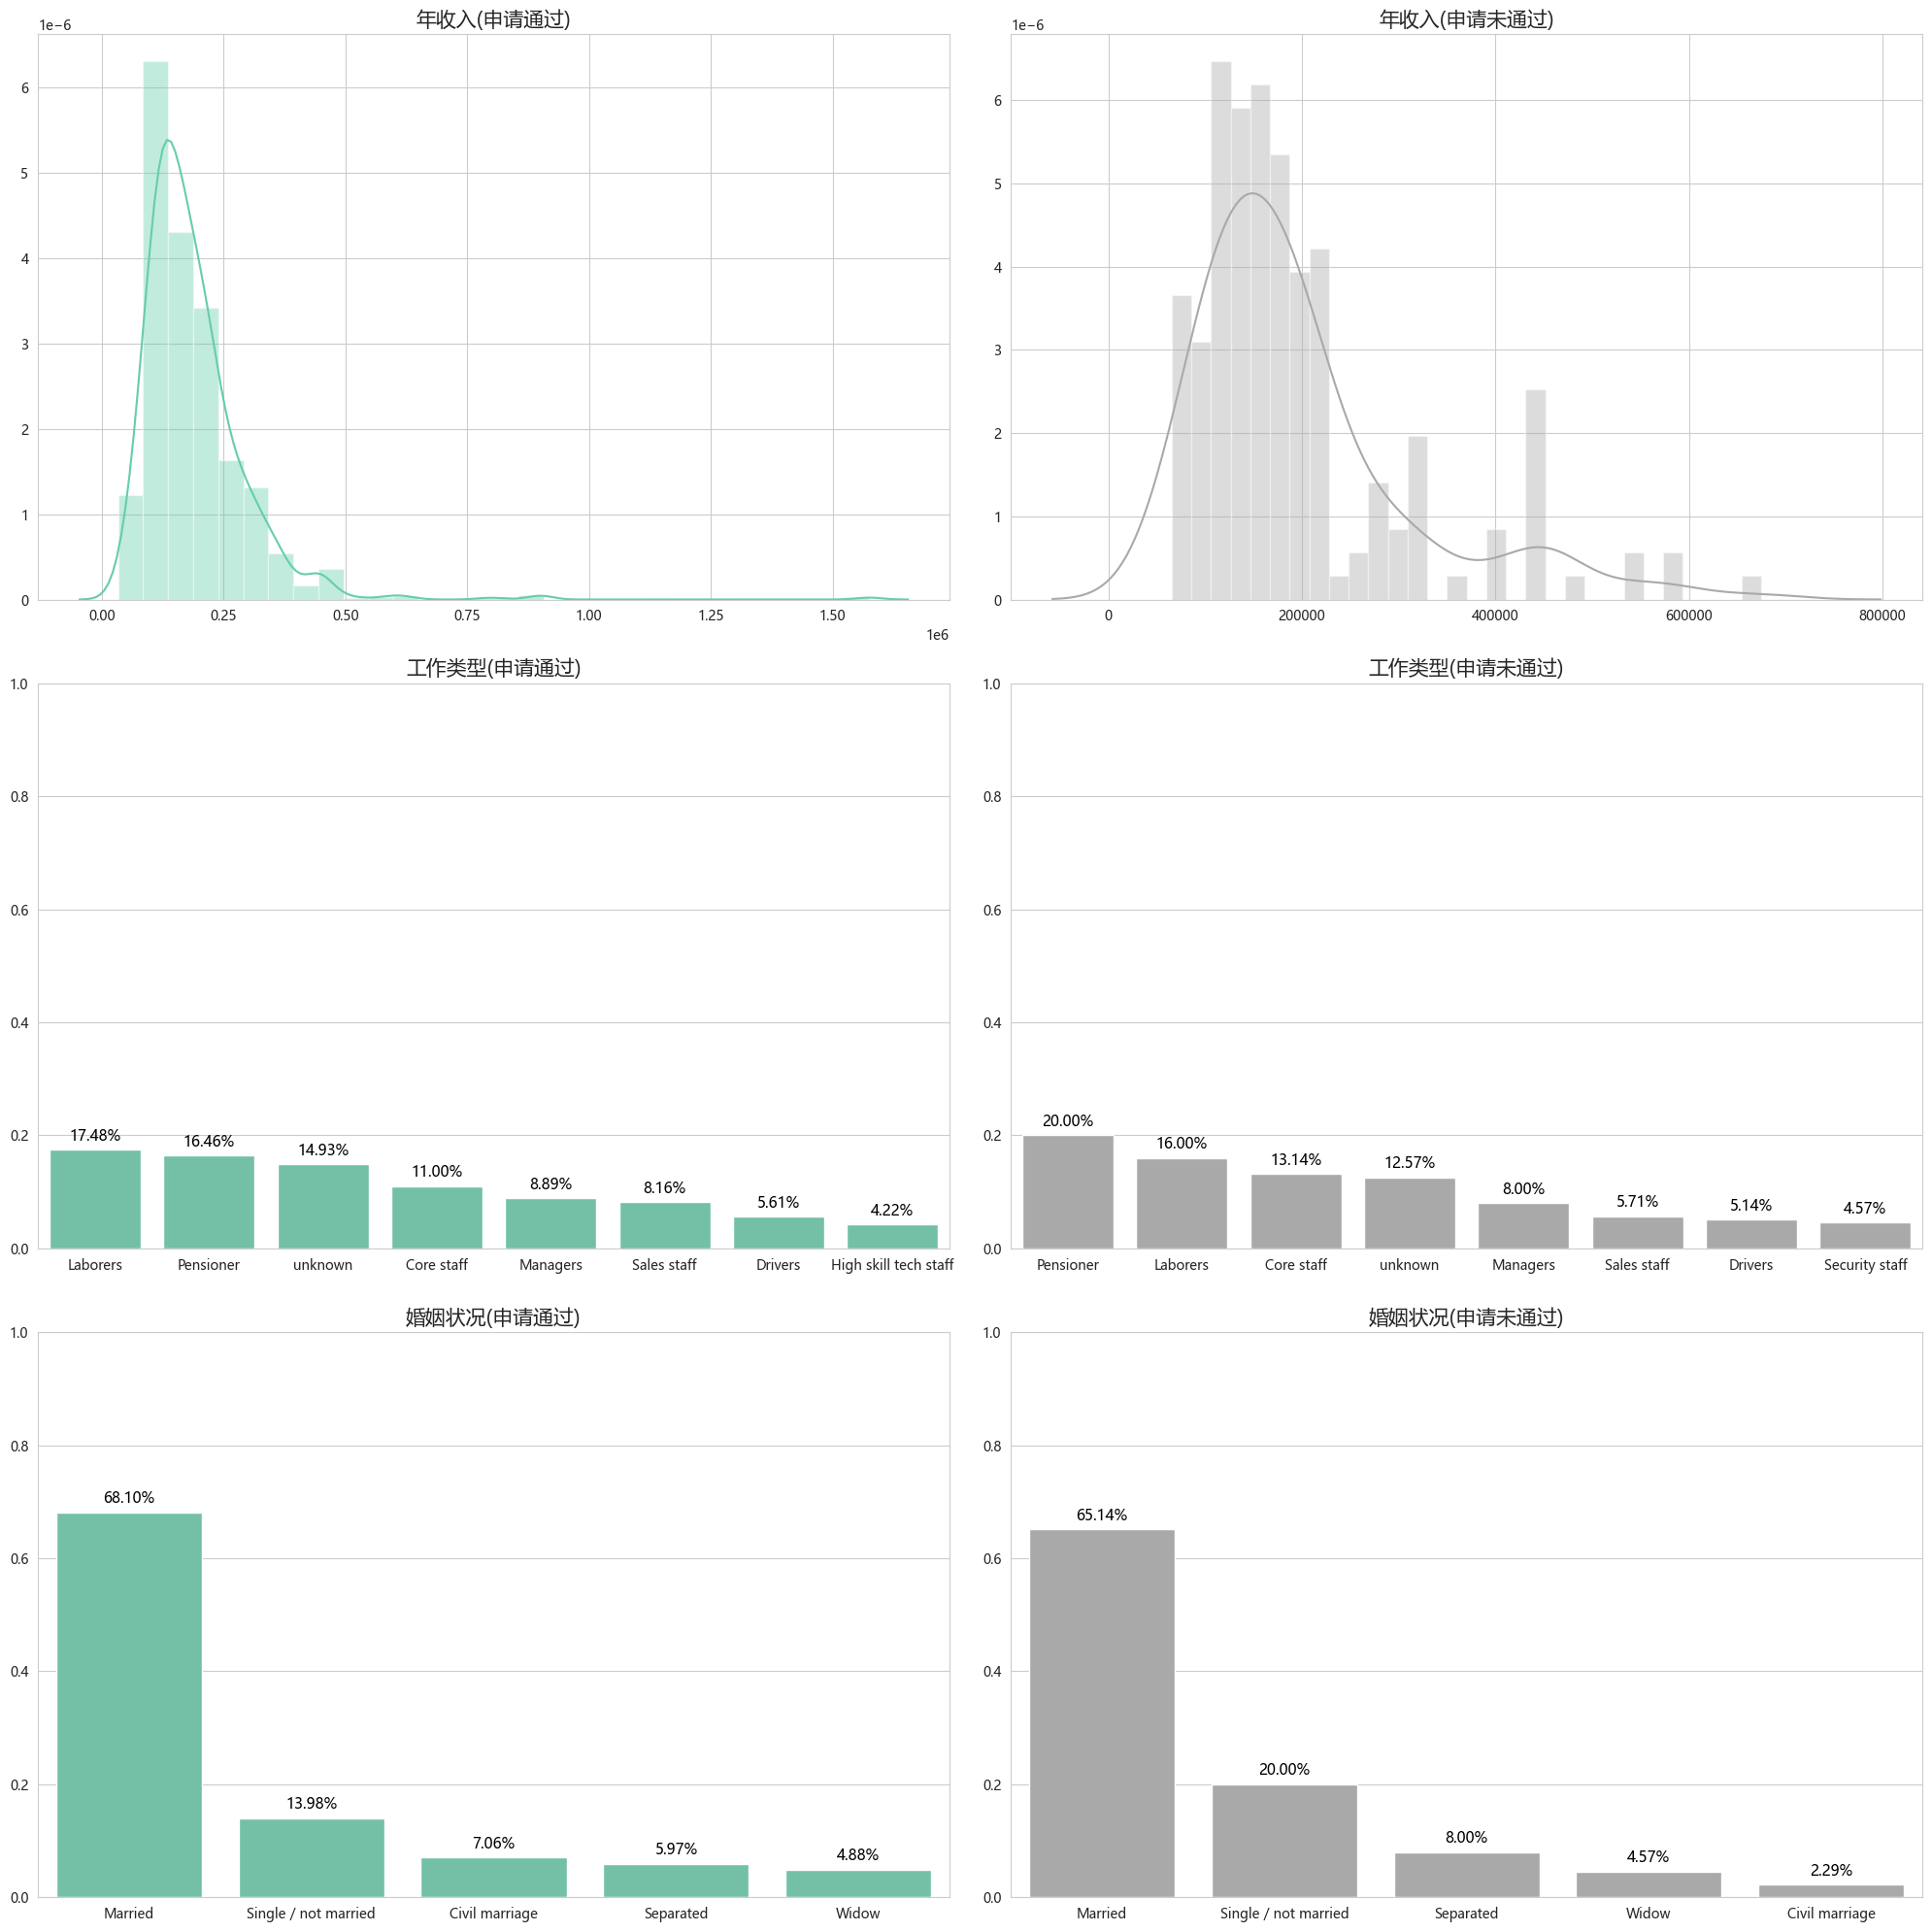

In [33]:
plt.figure(figsize=(20, 20))

#年收入
ax1 = plt.subplot(3, 2, 1)
sns.distplot(approved_data['Annual_income'], ax=ax1, color='#66cdaa', bins=30, kde=True)
ax1.set_title('年收入(申请通过)', fontsize=15)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax2 = plt.subplot(3, 2, 2)
sns.distplot(rejected_data['Annual_income'], ax=ax2, color='#a9a9a9', bins=30, kde=True)
ax2.set_title('年收入(申请未通过)', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('')

#工作类型，由于涉及工作类型较多，取前8进行可视化
ax3 = plt.subplot(3, 2, 3)
top_occupations_approved = approved_profile['Occupation Distribution'].head(8)
bar_plot_with_annotation(ax3, top_occupations_approved, '工作类型(申请通过)', '#66cdaa')

ax4 = plt.subplot(3, 2, 4)
top_occupations_rejected = rejected_profile['Occupation Distribution'].head(8)
bar_plot_with_annotation(ax4, top_occupations_rejected, '工作类型(申请未通过)', '#a9a9a9')

#婚姻状况
ax5 = plt.subplot(3, 2, 5)
bar_plot_with_annotation(ax5, approved_profile['Marital Status Distribution'], '婚姻状况(申请通过)', '#66cdaa')

ax6 = plt.subplot(3, 2, 6)
bar_plot_with_annotation(ax6, rejected_profile['Marital Status Distribution'], '婚姻状况(申请未通过)', '#a9a9a9')

plt.tight_layout()
plt.show()

## 模型训练

### 1.数据处理

In [34]:
# 删除Ind_ID
data.drop(columns=['Ind_ID'],axis=1, inplace=True)

# 将所有的Y替换成1，所有的N替换成0
data.replace({'Y': 1, 'N': 0}, inplace=True)

# 将M(男)替换成0，将F(女)替换成1
data.replace({'M': 0, 'F': 1}, inplace=True)

# 将教育情况列改为有序编码
education_mapping = {
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Incomplete higher': 2,
    'Higher education': 3,
    'Academic degree': 4
}
data['EDUCATION'] = data['EDUCATION'].map(education_mapping)

In [35]:
# 对分类数据独热编码:
categorical_cols = data.select_dtypes(include=['object']).columns
new_data = pd.get_dummies(data, columns=categorical_cols)

#对连续变量进行标准化
numerical_cols = ['Annual_income', 'Age', 'Employed_years', 'Family_Members', 'CHILDREN','EDUCATION']
scaler = StandardScaler() 
new_data[numerical_cols] = scaler.fit_transform(new_data[numerical_cols])

In [37]:
x = new_data.drop('label', axis=1)
y = new_data['label']

#划分训练集与测试集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1017, stratify=y) 

由于之前已经发现，样本中类别不平衡，label=0的样本远多于label=1的样本，又因为样本数量较少，因此考虑**过采样**方法使样本平衡

In [38]:
x_min= x_train[y_train == 1]
y_min = y_train[y_train == 1]
x_maj = x_train[y_train == 0]
y_maj = y_train[y_train == 0]

x_min_resampled = resample(x_min, replace=True, n_samples=len(x_maj), random_state=1017)
y_min_resampled = resample(y_min, replace=True, n_samples=len(y_maj), random_state=1017)
x_train = pd.concat([x_maj, x_min_resampled])
y_train = pd.concat([y_maj, y_min_resampled])

### 2.逻辑回归

In [52]:
logreg = LogisticRegression(random_state=1017)
logreg.fit(x_train, y_train)

LogisticRegression(random_state=1017)

In [53]:
y_pred = logreg.predict(x_test)
result_rep = classification_report(y_test, y_pred)
print(result_rep)

              precision    recall  f1-score   support

           0       0.90      0.68      0.77       412
           1       0.14      0.42      0.21        53

    accuracy                           0.65       465
   macro avg       0.52      0.55      0.49       465
weighted avg       0.81      0.65      0.71       465



逻辑回归模型评分如下:  
1.精确度: 对于类别0，精确度为0.90，对于类别1，精确度为0.14  
2.召回率: 对于类别0，召回率为0.68，对于类别1，召回率为0.42  
3.F1得分: 对于类别0，F1得分为0.77，对于类别1，F1得分为0.21  
4.总体准确率为0.65，模型效果一般

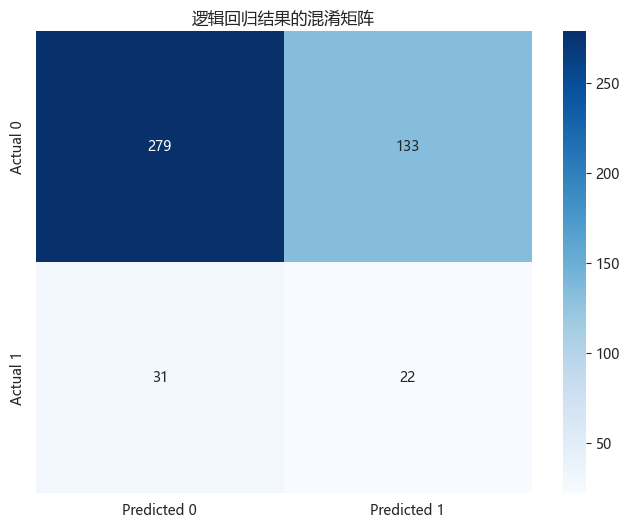

In [40]:
#绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('逻辑回归结果的混淆矩阵')
plt.show()

### 3.支持向量机(SVM)

In [54]:
svm_clf = SVC(kernel='rbf', probability=True, random_state=1017)
svm_clf.fit(x_train, y_train)

SVC(probability=True, random_state=1017)

In [55]:
y_pred_svm = svm_clf.predict(x_test)
rep_svm = classification_report(y_test, y_pred_svm)
print(rep_svm)

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       412
           1       0.21      0.42      0.28        53

    accuracy                           0.76       465
   macro avg       0.56      0.61      0.57       465
weighted avg       0.83      0.76      0.79       465



支持向量机模型评分如下:  
1.精确度: 对于类别0，精确度为0.91，对于类别1，精确度为0.21  
2.召回率: 对于类别0，召回率为0.80，对于类别1，召回率为0.42  
3.F1得分: 对于类别0，F1得分为0.85，对于类别1，F1得分为0.28  
4.总体准确率为0.76，模型效果一般，但优于逻辑回归模型

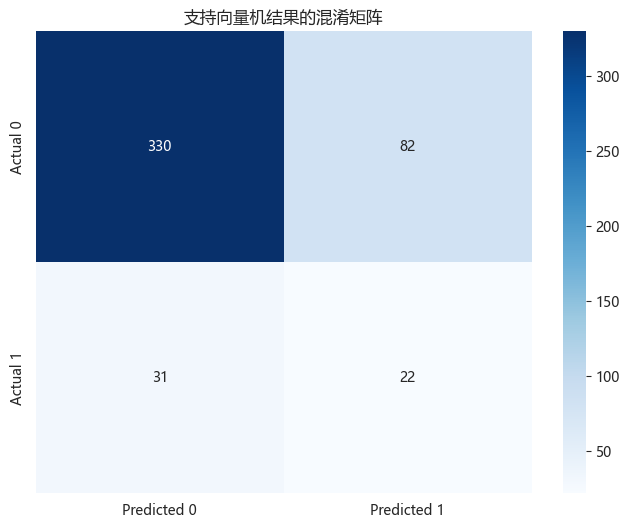

In [43]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('支持向量机结果的混淆矩阵')
plt.show()

### 4.决策树

In [56]:
tree_clf = tree.DecisionTreeClassifier(random_state=1017) 
tree_clf.fit(x_train,y_train)

DecisionTreeClassifier(random_state=1017)

In [57]:
y_pred_tree = tree_clf.predict(x_test)
rep_tree = classification_report(y_test, y_pred_tree)
print(rep_tree)

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       412
           1       0.41      0.43      0.42        53

    accuracy                           0.86       465
   macro avg       0.67      0.68      0.67       465
weighted avg       0.87      0.86      0.87       465



决策树模型评分如下:  
1.精确度: 对于类别0，精确度为0.93，对于类别1，精确度为0.41  
2.召回率: 对于类别0，召回率为0.92，对于类别1，召回率为0.43  
3.F1得分: 对于类别0，F1得分为0.92，对于类别1，F1得分为0.42  
4.总体准确率为0.86，模型效果良好，优于逻辑回归模型和支持向量机模型  

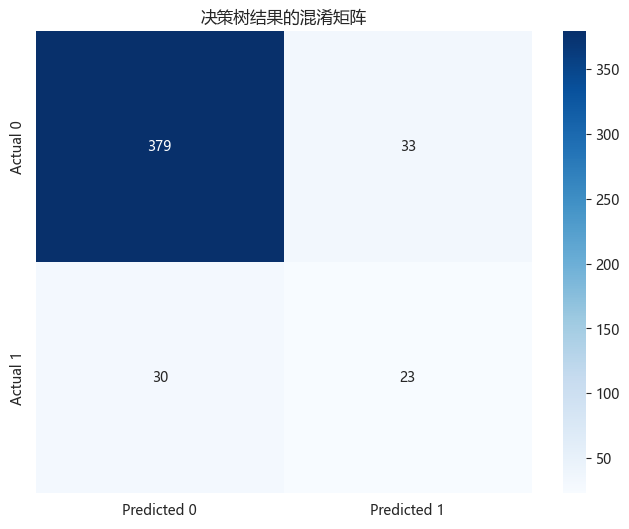

In [46]:
cm_tree = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('决策树结果的混淆矩阵')
plt.show()

### 5.贝叶斯

In [47]:
bys_clf = GaussianNB()
bys_clf.fit(x_train, y_train)

GaussianNB()

In [48]:
y_pred_bys = bys_clf.predict(x_test)
rep_bys = classification_report(y_test, y_pred_bys)
print(rep_bys)

              precision    recall  f1-score   support

           0       0.90      0.07      0.13       412
           1       0.12      0.94      0.21        53

    accuracy                           0.17       465
   macro avg       0.51      0.51      0.17       465
weighted avg       0.81      0.17      0.14       465



贝叶斯分类器评分如下:  
1.精确度: 对于类别0，精确度为0.9，对于类别1，精确度为0.12  
2.召回率: 对于类别0，召回率为0.07，对于类别1，召回率为0.94  
3.F1得分: 对于类别0，F1得分为0.13，对于类别1，F1得分为0.21  
4.总体准确率为0.17，模型效果极差  

### 6.神经网络

In [58]:
nw_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200, random_state=1017)
nw_clf.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), random_state=1017)

In [59]:
y_pred_nw = nw_clf.predict(x_test)
rep_nw = classification_report(y_test, y_pred_nw)
print(rep_nw)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       412
           1       0.51      0.42      0.46        53

    accuracy                           0.89       465
   macro avg       0.72      0.68      0.70       465
weighted avg       0.88      0.89      0.88       465



神经网络评分如下:  
1.精确度: 对于类别0，精确度为0.93，对于类别1，精确度为0.51  
2.召回率: 对于类别0，召回率为0.95，对于类别1，召回率为0.42  
3.F1得分: 对于类别0，F1得分为0.94，对于类别1，F1得分为0.46  
4.总体准确率为0.89，模型效果较好，目前为止最优  

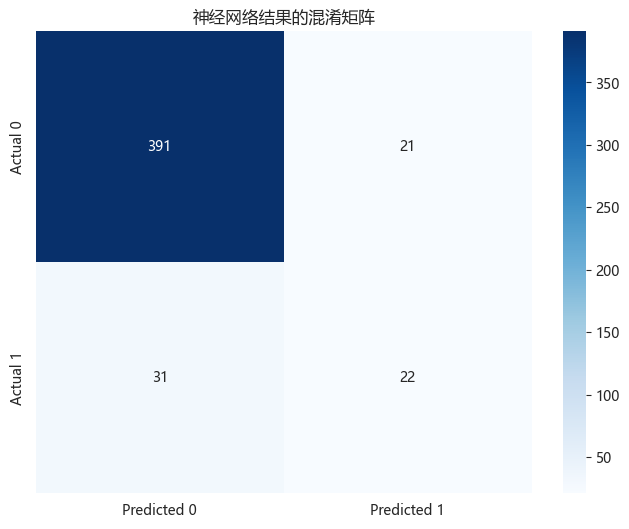

In [51]:
cm_nw = confusion_matrix(y_test, y_pred_nw)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nw, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('神经网络结果的混淆矩阵')
plt.show()

## stacking

In [42]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone

class StackingClassifier(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
    
    def fit(self, X, y):
        self.base_models_ = [clone(model) for model in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        
        # 训练基础模型
        for model in self.base_models_:
            model.fit(X, y)
        
        # 生成基础模型的预测结果作为元特征
        meta_features = np.column_stack([
            model.predict(X) for model in self.base_models_
        ])
        
        # 训练元模型
        self.meta_model_.fit(meta_features, y)
        
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            model.predict(X) for model in self.base_models_
        ])
        return self.meta_model_.predict(meta_features)

#### staking(基模型：逻辑回归+随机森林+SVM  元模型：逻辑回归)

In [45]:
# 定义基础模型
base_models = [
    LogisticRegression(),
    RandomForestClassifier(n_estimators=10, random_state=1017),
    SVC()
]

# 定义元模型
meta_model = LogisticRegression()

# 定义Stacking模型
stacking = StackingClassifier(base_models, meta_model)

# 拟合数据
stacking.fit(x_train, y_train)

# 预测数据
y_pred = stacking.predict(x_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9204301075268817


In [46]:
rep_sta = classification_report(y_test, y_pred)
print(rep_sta)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       412
           1       0.81      0.40      0.53        53

    accuracy                           0.92       465
   macro avg       0.87      0.69      0.74       465
weighted avg       0.91      0.92      0.91       465



#### staking(基模型：神经网络+随机森林+SVM 元模型：逻辑回归)¶

In [63]:
base_models = [
    MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200, random_state=1017),
    RandomForestClassifier(n_estimators=10, random_state=1017),
    SVC()
]

meta_model = LogisticRegression()

stacking = StackingClassifier(base_models, meta_model)

stacking.fit(x_train, y_train)

y_pred = stacking.predict(x_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9225806451612903


In [64]:
rep_sta = classification_report(y_test, y_pred)
print(rep_sta)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       412
           1       0.84      0.40      0.54        53

    accuracy                           0.92       465
   macro avg       0.88      0.69      0.75       465
weighted avg       0.92      0.92      0.91       465



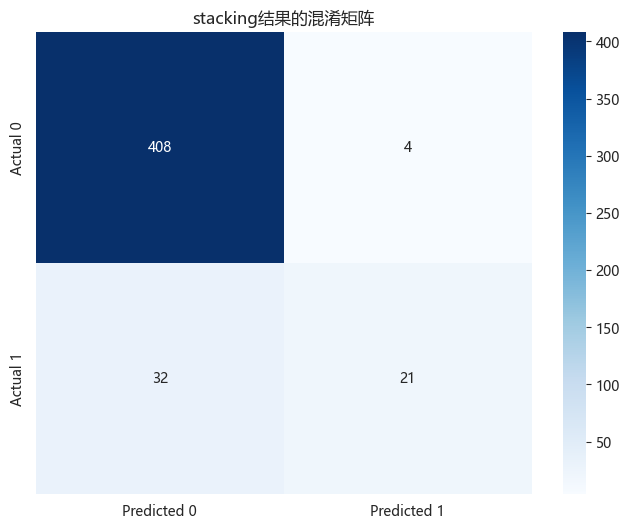

In [66]:
cm_st = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_st, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('stacking结果的混淆矩阵')
plt.show()

## voting

#### 三模型voting

In [52]:
three_predictions = np.array([y_pred_svm, y_pred_tree, y_pred_nw])
three_pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=three_predictions)

In [53]:
rep_three = classification_report(y_test, three_pred)
print(rep_three)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       412
           1       0.48      0.43      0.46        53

    accuracy                           0.88       465
   macro avg       0.70      0.69      0.69       465
weighted avg       0.88      0.88      0.88       465



#### 四模型voting

In [60]:
four_predictions = np.array([y_pred, y_pred_svm, y_pred_tree, y_pred_nw])
four_pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=four_predictions)

In [61]:
rep_four = classification_report(y_test, four_pred)
print(rep_four)

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       412
           1       0.47      0.36      0.41        53

    accuracy                           0.88       465
   macro avg       0.70      0.65      0.67       465
weighted avg       0.87      0.88      0.87       465



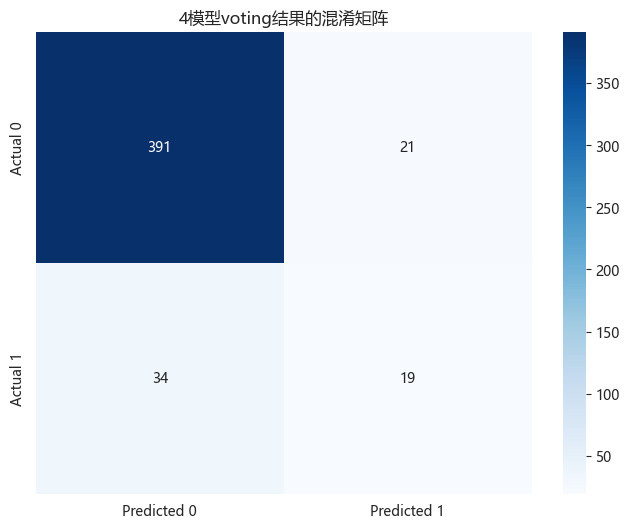

In [62]:
cm_four = confusion_matrix(y_test, four_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_four, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('4模型voting结果的混淆矩阵')
plt.show()

可以看到voting后模型的**效果不升反降**，特别是在**不通过**类型的识别上表现较差

## bagging

In [57]:
from sklearn.base import clone

class Bagging:
    def __init__(self, base_estimator, n_estimators):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.estimators = []
        self.selected_features = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            # 从原始训练集中有放回地抽样生成子训练集
            indices = np.random.choice(len(X), size=900, replace=True)
            X = np.array(X)
            y = np.array(y)
            X_subset = X[indices]
            y_subset = y[indices]
            
            # 随机选择特征
            num_features = X.shape[1]
            selected_features = np.random.choice(num_features, size=30, replace=False)
            self.selected_features.append(selected_features)
            X_subset = X_subset[:, selected_features]

            # 训练学习器并加入到集成模型中
            estimator = clone(self.base_estimator)
            estimator.fit(X_subset, y_subset)
            self.estimators.append(estimator)

    def predict(self, X):
        predictions = np.zeros((len(X), self.n_estimators))
        for i, estimator in enumerate(self.estimators):
            X_subset = X.iloc[:, self.selected_features[i]]
            # 使用每个学习器进行预测
            predictions[:, i] = estimator.predict(X_subset)

        # 使用投票策略集成预测结果
        ensemble_predictions = np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x.astype(int))),
            axis=1,
            arr=predictions
        )
        return ensemble_predictions

### 决策树bagging+随机特征选择（RF）

In [58]:
base_clf = tree.DecisionTreeClassifier()
bagging = Bagging(base_clf, n_estimators=100)

bagging.fit(x_train, y_train)
y_pred_bag = bagging.predict(x_test)
rep_bag = classification_report(y_test, y_pred_bag)
print(rep_bag)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       412
           1       0.69      0.42      0.52        53

    accuracy                           0.91       465
   macro avg       0.81      0.70      0.73       465
weighted avg       0.90      0.91      0.90       465



bagging效果良好，对申请不通过的区分能力有了很大的提升

**使用sklearn包中的随机森林**

In [59]:
rf_clf = RandomForestClassifier(random_state=1017)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(random_state=1017)

In [60]:
y_pred_rf = rf_clf.predict(x_test)
class_report_rf = classification_report(y_test, y_pred_rf)
print(class_report_rf)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       412
           1       0.84      0.40      0.54        53

    accuracy                           0.92       465
   macro avg       0.88      0.69      0.75       465
weighted avg       0.92      0.92      0.91       465



随机森林模型的效果很好，与自己编写的RF相比更优

下面进行其他模型的bagging

In [31]:
class Bagging:
    def __init__(self, base_estimator, n_estimators):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.estimators = []
        self.selected_features = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            # 从原始训练集中有放回地抽样生成子训练集
            indices = np.random.choice(len(X), size=900, replace=True)
            X = np.array(X)
            y = np.array(y)
            X_subset = X[indices]
            y_subset = y[indices]
            
            # 随机选择特征(size=特征数时，即为49时，则是普通bagging)
            num_features = X.shape[1]
            selected_features = np.random.choice(num_features, size=49, replace=False)
            self.selected_features.append(selected_features)
            X_subset = X_subset[:, selected_features]

            # 训练学习器并加入到集成模型中
            estimator = clone(self.base_estimator)
            estimator.fit(X_subset, y_subset)
            self.estimators.append(estimator)

    def predict(self, X):
        predictions = np.zeros((len(X), self.n_estimators))
        for i, estimator in enumerate(self.estimators):
            X_subset = X.iloc[:, self.selected_features[i]]
            # 使用每个学习器进行预测
            predictions[:, i] = estimator.predict(X_subset)

        # 使用投票策略集成预测结果
        ensemble_predictions = np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x.astype(int))),
            axis=1,
            arr=predictions
        )
        return ensemble_predictions

### 支持向量机bagging

In [61]:
base_clf = SVC(kernel='rbf', probability=True)
bagging_svm = Bagging(base_clf, n_estimators=10)

bagging_svm.fit(x_train, y_train)
y_pred_bag_svm = bagging_svm.predict(x_test)
rep_bag_svm = classification_report(y_test, y_pred_bag_svm)
print(rep_bag_svm)

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       412
           1       0.20      0.38      0.26        53

    accuracy                           0.75       465
   macro avg       0.55      0.59      0.56       465
weighted avg       0.83      0.75      0.79       465



基于SVM的bagging效果并不好

### 神经网络bagging

In [70]:
base_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200)
bagging_nw = Bagging(base_clf, n_estimators=30)

bagging_nw.fit(x_train, y_train)
y_pred_bag_nw = bagging_nw.predict(x_test)
rep_bag_nw = classification_report(y_test, y_pred_bag_nw)
print(rep_bag_nw)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       412
           1       0.49      0.45      0.47        53

    accuracy                           0.88       465
   macro avg       0.71      0.70      0.70       465
weighted avg       0.88      0.88      0.88       465



可以发现，神经网络做bagging的效果相较于单纯的神经网络模型并没有提升

## boosting

In [92]:
class Boosting:
    def __init__(self, base_classifier, n_estimators=5):
        self.n_estimators = n_estimators
        self.models = []
        self.weights = []
        self.base_classifier = base_classifier

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # 初始化样本权重
        sample_weights = np.ones(n_samples) / n_samples

        for i in range(self.n_estimators):
            model = clone(self.base_classifier)
            # 使用带权重的样本进行训练
            model.fit(X, y, sample_weight=sample_weights)
            
            predictions = model.predict(X)
            
            error = np.sum(sample_weights * (predictions != y)) / np.sum(sample_weights)
            model_weight = 0.5 * np.log((1 - error) / error)
            
            # 更新样本权重
            sample_weights *= np.exp(-model_weight * y * predictions)
            sample_weights /= np.sum(sample_weights)
            
            # 保存模型和权重
            self.models.append(model)
            self.weights.append(model_weight)

    def predict(self, X):
        # 对每个模型的预测结果进行加权平均
        predictions = np.zeros(X.shape[0])
        for model, weight in zip(self.models, self.weights):
            predictions += weight * model.predict(X)
        
        # 使用符号函数将结果映射到二分类标签
        return np.sign(predictions).astype(int)

### 决策树boosting

In [109]:
base_clf = tree.DecisionTreeClassifier()
boost_tree = Boosting(base_clf, 10)
boost_tree.fit(x_train, y_train)

y_pred_boost_tr = boost_tree.predict(x_test)
rep_boost_tr = classification_report(y_test, y_pred_boost_tr)
print(rep_boost_tr)

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       412
           1       0.23      0.58      0.33        53

    accuracy                           0.73       465
   macro avg       0.58      0.67      0.58       465
weighted avg       0.85      0.73      0.77       465



### 调用adaboost

In [110]:
model_ada = AdaBoostClassifier(n_estimators=10, learning_rate=1)
model_ada.fit(x_train, y_train)

y_pred_ada = model_ada.predict(x_test)
class_report_ada = classification_report(y_test, y_pred_ada)
print(class_report_ada)

              precision    recall  f1-score   support

           0       0.90      0.69      0.78       412
           1       0.15      0.42      0.22        53

    accuracy                           0.66       465
   macro avg       0.52      0.55      0.50       465
weighted avg       0.82      0.66      0.72       465



可以发现，无论是自己编写的决策树boosting集成算法还是调用sklearn包中的adaboost，模型都未取得良好的效果

### 支持向量机boosting

In [111]:
base_clf = SVC(kernel='rbf', probability=True, random_state=1017)
boost_svm = Boosting(base_clf, 10)
boost_svm.fit(x_train, y_train)

y_pred_boost_svm = boost_svm.predict(x_test)
rep_boost_svm = classification_report(y_test, y_pred_boost_svm)
print(rep_boost_svm)

              precision    recall  f1-score   support

           0       0.93      0.45      0.61       412
           1       0.14      0.72      0.24        53

    accuracy                           0.48       465
   macro avg       0.54      0.59      0.42       465
weighted avg       0.84      0.48      0.57       465



对支持向量机使用boosting集成方法效果极差

### 调用xgboost

In [101]:
xgb_clf = xgb.XGBClassifier(random_state=1017, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(x_train, y_train)

y_pred_xgb = xgb_clf.predict(x_test)
class_report_xgb = classification_report(y_test, y_pred_xgb)
print(class_report_xgb)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       412
           1       0.60      0.45      0.52        53

    accuracy                           0.90       465
   macro avg       0.77      0.71      0.73       465
weighted avg       0.89      0.90      0.90       465



xgboost模型的效果较好

## 参数调整

从以上模型的混淆矩阵可以看出，随机森林模型、xgboost模型、stacking模型具有良好的效果，故使用网格搜索进行调参

### Stacking

In [74]:
from sklearn.ensemble import StackingClassifier

base_models = [
    ('mlp', MLPClassifier()), 
    ('rf', RandomForestClassifier()),
    ('svm', SVC()),
]

meta_model = LogisticRegression()

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# 定义参数网格
param_grid = {
   'rf__n_estimators': [10, 50],
    'svm__kernel': ['linear', 'rbf'],
}

# 实例化网格搜索对象
grid_search = GridSearchCV(stacking_model, param_grid, cv=5, n_jobs=-1,verbose=1)

# 进行网格搜索
grid_search.fit(x_train, y_train)

# 选择最佳模型
best_stacking_model = grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [76]:
y_pred_sta = best_stacking_model.predict(x_test)
class_report_sta = classification_report(y_test, y_pred_sta)
print(class_report_sta)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       412
           1       0.87      0.38      0.53        53

    accuracy                           0.92       465
   macro avg       0.90      0.69      0.74       465
weighted avg       0.92      0.92      0.91       465



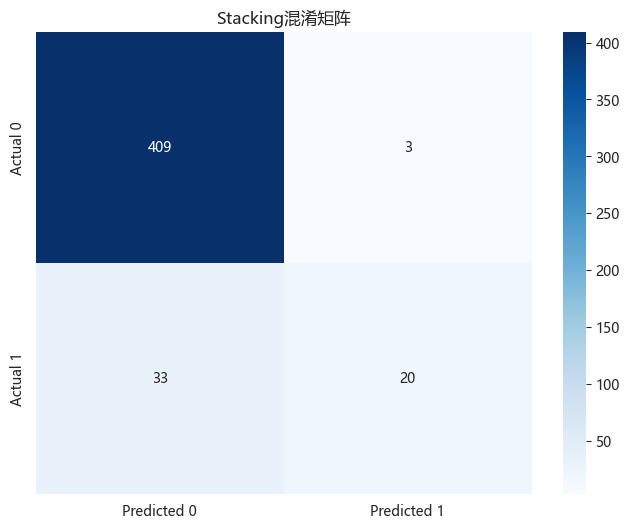

In [77]:
cm_sta = confusion_matrix(y_test, y_pred_sta)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_sta, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Stacking混淆矩阵')
plt.show()

### 随机森林

In [112]:
param_grid = {
    'n_estimators':[10,50,100], #决策树的数量
    'max_depth':[None,10,20,30],#决策树的最大深度
    'min_samples_split':[2,5,10],#决定节点分裂的最小样本数量
    'min_samples_leaf':[1,2,4],#决定叶节点的最小样本数量
    'max_features':['auto','sqrt','log2'] #考虑分裂时的特征数量
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,n_jobs=-1,verbose=1) 
grid_search.fit(x_train,y_train)
print('Best parameters found:',grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [113]:
best_rf = grid_search.best_estimator_
y_pred_orf = best_rf.predict(x_test)
class_report_orf = classification_report(y_test, y_pred_orf)
print(class_report_orf)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       412
           1       0.81      0.40      0.53        53

    accuracy                           0.92       465
   macro avg       0.87      0.69      0.74       465
weighted avg       0.91      0.92      0.91       465



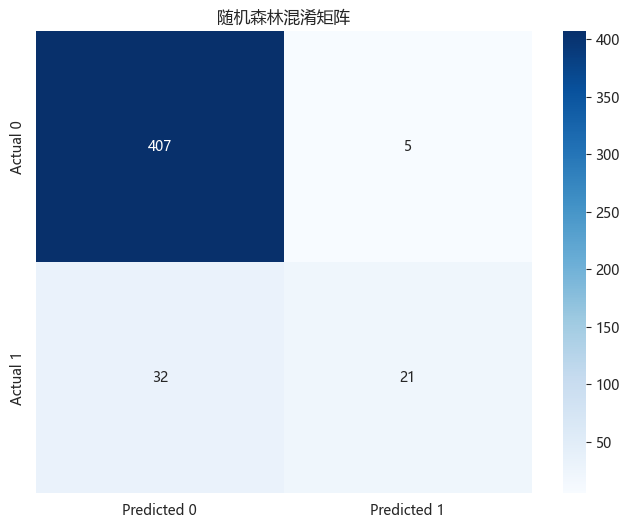

In [115]:
cm_orf = confusion_matrix(y_test, y_pred_orf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_orf, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('随机森林混淆矩阵')
plt.show()

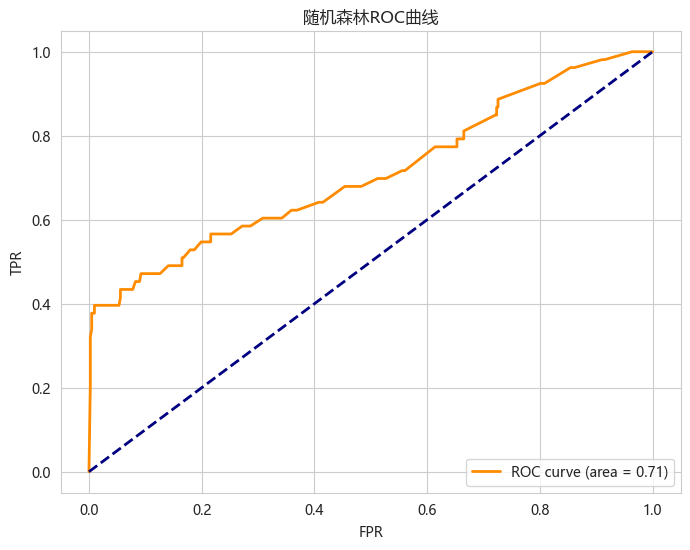

In [117]:
#绘制ROU曲线
fpr_orf, tpr_orf, _ = roc_curve(y_test, best_rf.predict_proba(x_test)[:, 1])
roc_auc_orf = auc(fpr_orf, tpr_orf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_orf, tpr_orf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_orf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('随机森林ROC曲线')
plt.legend(loc="lower right")
plt.show()

### xgboost

In [125]:
param_grid = {
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':[100,500,1000],
    'max_depth':[3,5,10],
    'min_child_weight':[1,3,5],
    'gamma':[0,0.1,0.2],
    'subsample':[0.8,1.0],
    'colsample_bytree':[0.8,1.0],
    'objective':['binary:logistic']
}
best_xgb = xgb.XGBClassifier()
grid_search = GridSearchCV(estimator=best_xgb,param_grid=param_grid,cv=5,n_jobs=-1,verbose=1)
grid_search.fit(x_train,y_train)
print('Best parameters found:',grid_search.best_params_)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'binary:logistic', 'subsample': 1.0}


In [126]:
best_xgb = grid_search.best_estimator_
y_pred_oxgb = best_xgb.predict(x_test)
class_report_oxgb = classification_report(y_test, y_pred_oxgb)
print(class_report_oxgb)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       412
           1       0.67      0.42      0.51        53

    accuracy                           0.91       465
   macro avg       0.80      0.69      0.73       465
weighted avg       0.90      0.91      0.90       465



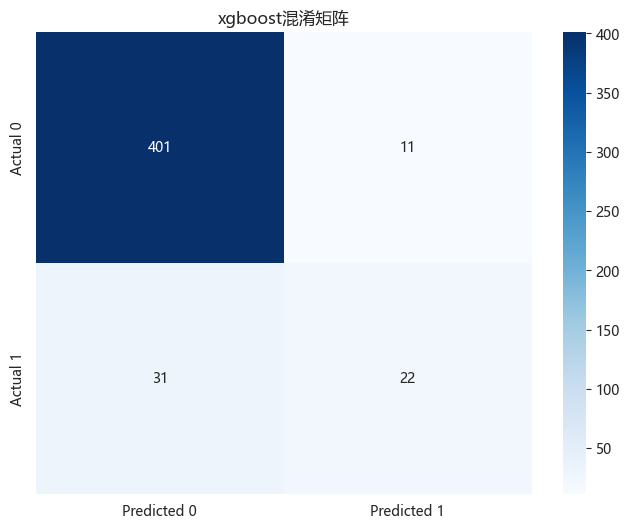

In [127]:
cm_oxgb = confusion_matrix(y_test, y_pred_oxgb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_oxgb, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('xgboost混淆矩阵')
plt.show()

In [130]:
rf_feature_importance = best_rf.feature_importances_
feature_names = x_train.columns
rf_feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_feature_importance
})
sorted_rf_feature_df = rf_feature_df.sort_values(by='Importance', ascending=False).head(6) #筛选出重要特征

sorted_rf_feature_df

,Feature,Importance
11,Age,0.157169
4,Annual_income,0.142510
13,Employed_years,0.128894
10,Family_Members,0.044000
5,EDUCATION,0.043111
3,CHILDREN,0.029716


可以看出在特征中，前6个重要特征为：Age>Annual_income>Employed_years>Family_Members>EDUCATION>CHILDREN，这对未来银行的信用识别具有一定的指导意义